# COMSW4995 - Applied Machine Learning - Hw 2

#### Hojin Lee (hl3328)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, GridSearchCV
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

## Task 2: Regression on Sydney Dataset

In [3]:
#reading data frame
directory = os.path.join(os.getcwd(),'Data/housedata/data.csv')
housing_df = pd.read_csv(directory)
housing_df.shape

(4600, 18)

#### 2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.

In [4]:
#Since sales price cannot be 0, we need to drop= rows where price = 0, which are invalid data points.
housing_df.drop(housing_df[housing_df['price'] <= 0].index, inplace=True)

#changing waterfront, view, condition to categorical variable 
housing_df[['waterfront', 'view', 'condition']] = housing_df[['waterfront', 'view', 'condition']].apply(lambda x: x.astype('object'))

#taking columns of object 
print('Categorical feature:',list(housing_df.select_dtypes(include=['object']).columns))
print('Continuous feature:',list(housing_df.select_dtypes(exclude=['object']).columns))

Categorical feature: ['date', 'waterfront', 'view', 'condition', 'street', 'city', 'statezip', 'country']
Continuous feature: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


#### 2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?

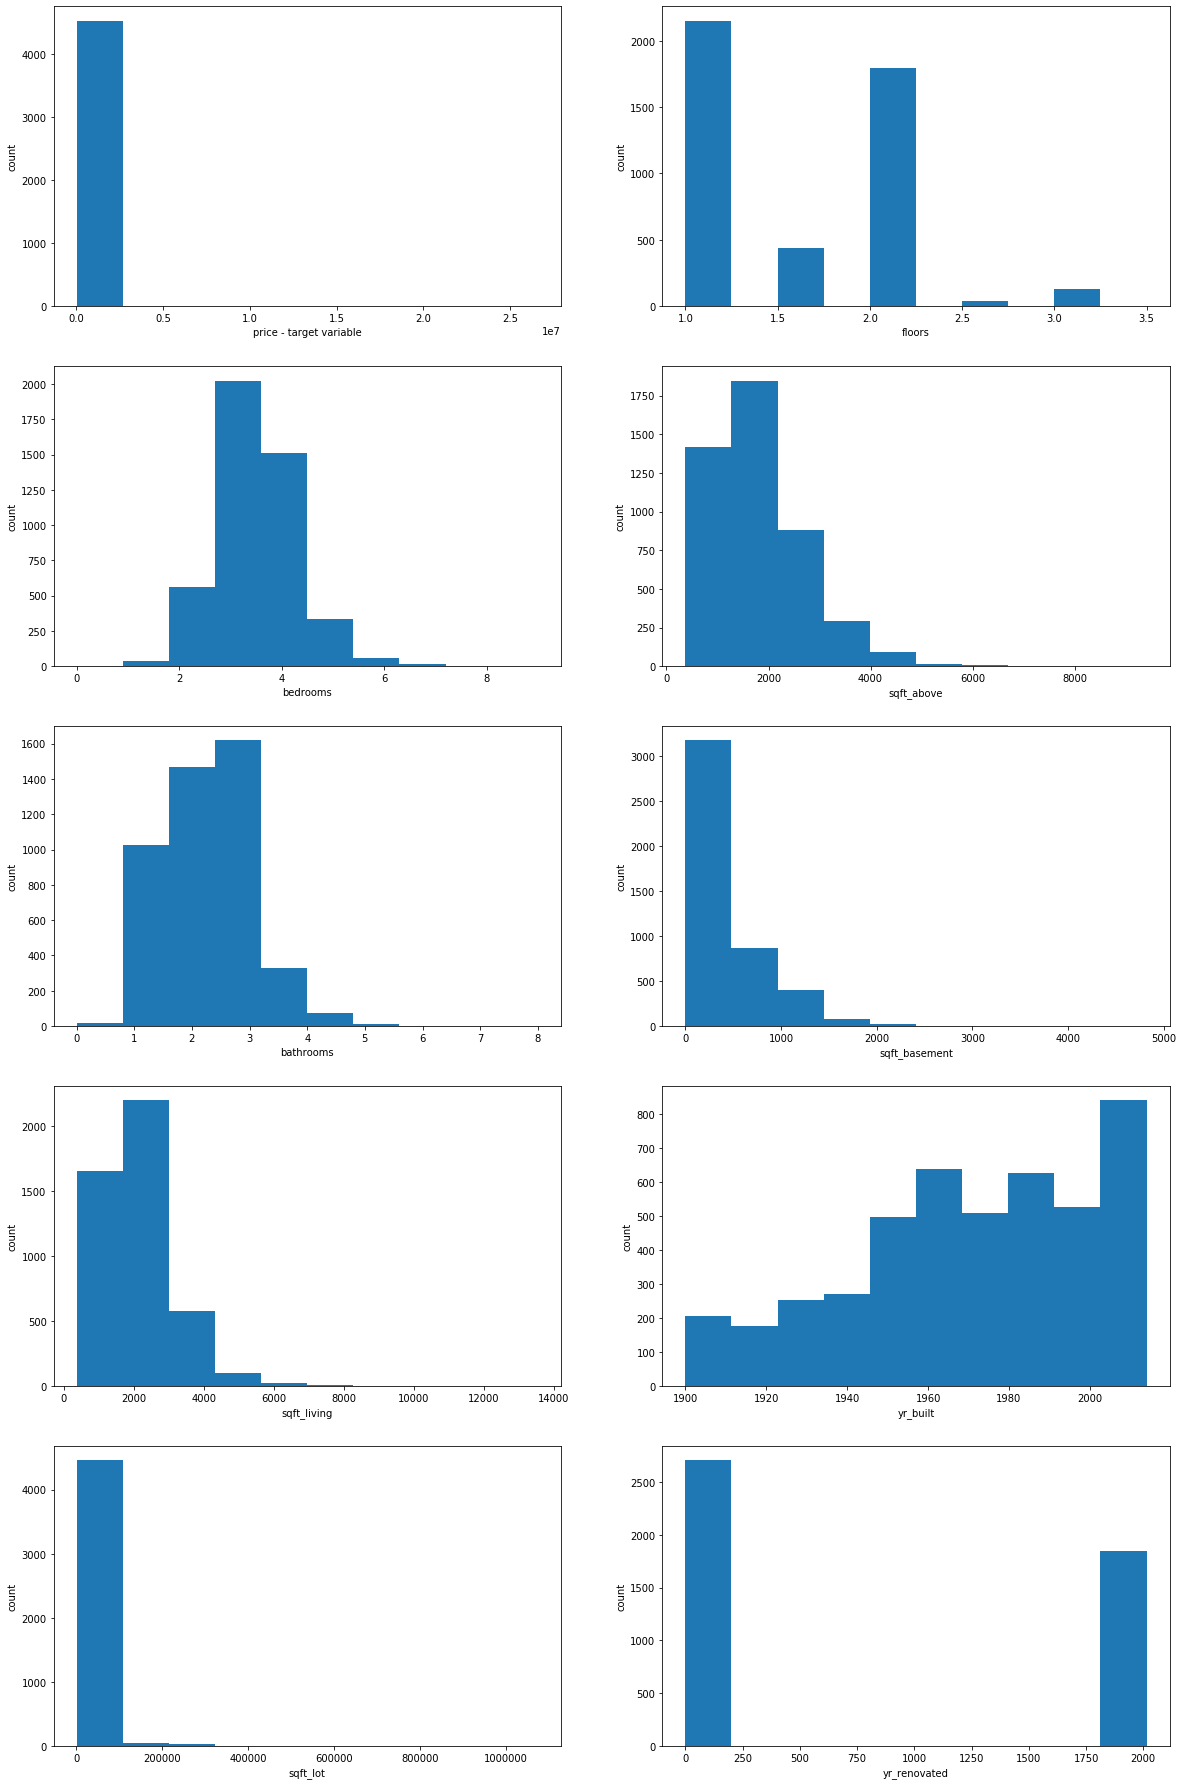

In [6]:
continuous_col = list(housing_df.select_dtypes(exclude=['object']).columns)
fig, ax = plt.subplots(5, 2, figsize=(20, 32))
i,j = 0,0
len(continuous_col)

for col in continuous_col:
    if i == 5:
        j += 1
        i = 0
    ax[i,j].hist(housing_df[col]);
    if col == 'price':
        ax[i,j].set_xlabel('price - target variable')
    else:
        ax[i,j].set_xlabel(col);
    ax[i,j].set_ylabel("count");
    i += 1


I have detected several issues while visualzing continous variables. First, I have noticed that there exists huge values in price column, which almost seem like an outlier. It seems reasonable to rescale the price variable with log-scale for visualization to fix the skewness of the histogram. There exist similar issue with sqft_lot and sqft_basement. Also, there are a lot of 0s in yr_renovatd feature. Assuming it is a missing value, further action is required on this feature. 

#### 2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).

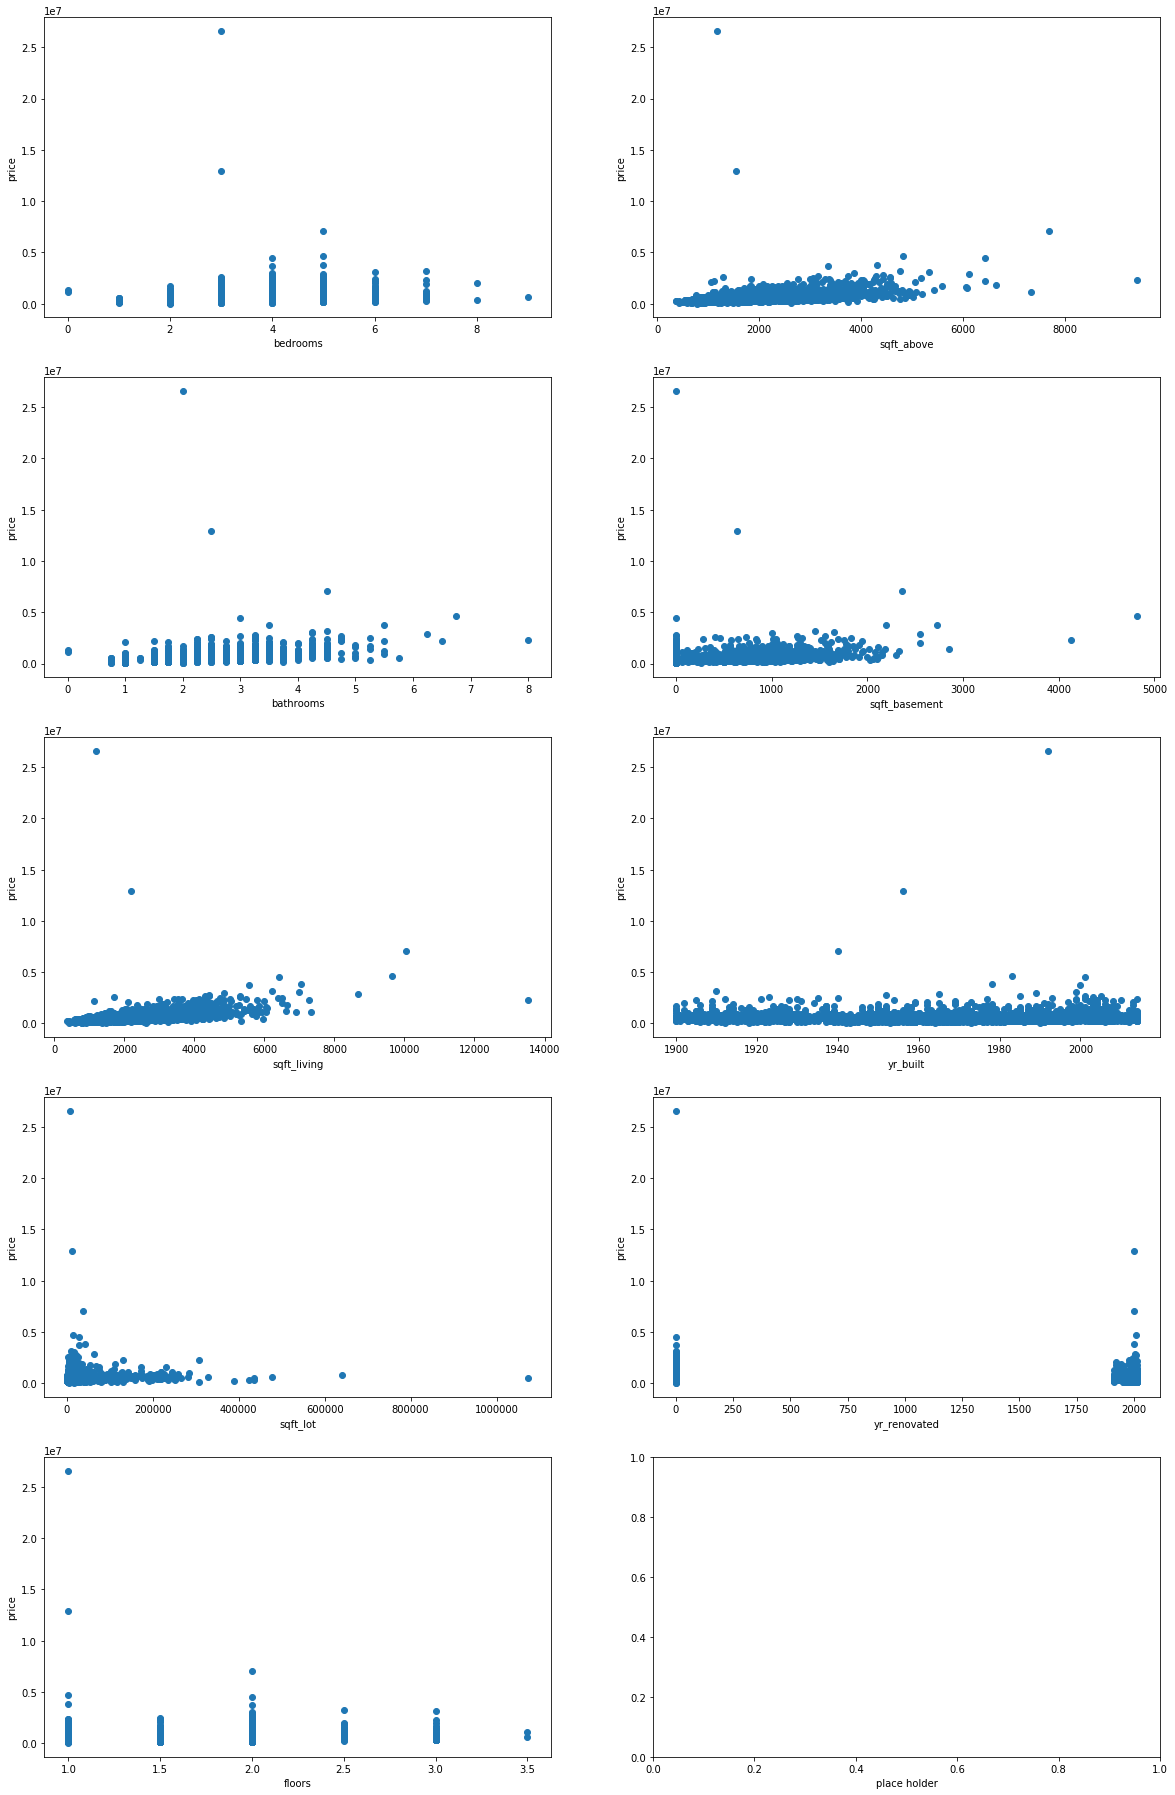

In [7]:
fig, ax = plt.subplots(5, 2, figsize=(20, 32))
i,j = 0,0
#removing price column from the list
del continuous_col[continuous_col.index("price")]

for col in continuous_col:
    if i == 5:
        j += 1
        i = 0
    ax[i,j].scatter(housing_df[col], housing_df['price'])
    ax[i,j].set_xlabel(col);
    ax[i,j].set_ylabel("price");
    i += 1

#empty plot due to odd number of plots
ax[i,j].set_xlabel('place holder');

#### 2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5. Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help? Use the preprocessing that works best going forward.

In [9]:
#droping country and street column as they are irrelevant with regression
housing_df.drop(columns=['street', 'country', 'date'], errors='ignore', inplace=True)

X = housing_df.loc[:, housing_df.columns != 'price']
y = housing_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

categorical = X.dtypes == object

cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(handle_unknown='ignore'))

cont_preprocessing = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

cont_preprocessing_without_scaler = make_pipeline(
    SimpleImputer(strategy='median'))

preprocess = make_column_transformer(
    (cat_preprocessing, 
     make_column_selector(dtype_include='object')),
     remainder=cont_preprocessing)

preprocess_without_scaler = make_column_transformer(
    (cat_preprocessing, 
     make_column_selector(dtype_include='object')),
     remainder=cont_preprocessing_without_scaler)

processors = [preprocess, preprocess_without_scaler]
methods = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
processors_name = ['preprocess with scaler', 'preprocess without scaler']
methods_name = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
scores = {}

processor_counter = 0

for processor in processors:
    methods_counter = 0
    scores[processors_name[processor_counter]] = {}
    for method in methods:
        scores[processors_name[processor_counter]][methods_name[methods_counter]] = np.mean(
            cross_val_score(make_pipeline(processor, method), X_train, y_train, cv=10))
        methods_counter += 1
    processor_counter += 1

score_df = pd.DataFrame.from_dict(scores)
print(tabulate(score_df, headers='keys', tablefmt='psql'))


+------------------+--------------------------+-----------------------------+
|                  |   preprocess with scaler |   preprocess without scaler |
|------------------+--------------------------+-----------------------------|
| LinearRegression |                 0.633071 |                    0.633455 |
| Ridge            |                 0.635665 |                    0.468152 |
| Lasso            |                 0.633149 |                    0.633149 |
| ElasticNet       |                 0.48046  |                    0.507143 |
+------------------+--------------------------+-----------------------------+


From the table above, we can observe the ridge regression with scaling with StandardScaler had the highest score. On the other hand, the ridge regression without the scaler had the lowest score. From this, we know that the ridge regressions gets affected greatly by the scaler. For the linear regression and the lasso regression, the score for with and without scaler were not significantly different. For the elastic net, $R^2$ improved slightly after implementing the scaler. According to the table result, going forward, I will use preprocessor with scaler as the best performing model.

#### 2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

==========  ====================  =====================  ========================================================
..          ridge                 lasso                  elasticNet
==========  ====================  =====================  ========================================================
best score  0.6418                0.6359                 0.6415
best param  {'ridge__alpha': 10}  {'lasso__alpha': 100}  {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.8}
==========  ====================  =====================  ========================================================


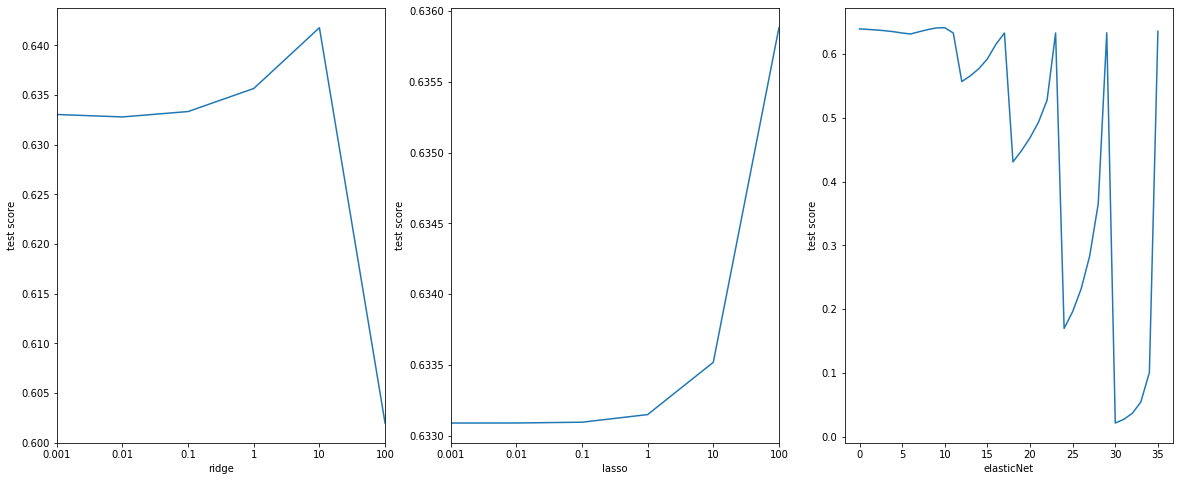

In [10]:
methods = [Ridge(), Lasso(), ElasticNet()]
method_name = ['ridge', 'lasso', 'elasticNet']
param_grids = {'ridge':{'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'lasso': {'lasso__alpha':  [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'elasticNet': {'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
                                 ,'elasticnet__l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]}}

results_dict = {}
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

method_counter = 0
for method in methods:
    param_grid = param_grids[method_name[method_counter]]
    model = GridSearchCV(make_pipeline(preprocess, method), param_grid, cv=10)
    model.fit(X_train, y_train)
    results_dict[method_name[method_counter]] = {}
    results_dict[method_name[method_counter]]['best score'] = (round(model.best_score_,4))
    results_dict[method_name[method_counter]]['best param'] = model.best_params_
    
    if method_counter <2:
        pd.DataFrame(model.cv_results_['mean_test_score'],list(map(str, list(param_grid.values())[0]))).plot(ax=ax[method_counter])
        ax[method_counter].get_legend().remove()
        ax[method_counter].set_xlabel(method_name[method_counter]);
        ax[method_counter].set_ylabel("test score");    
    
    else:
        ax[method_counter].plot(model.cv_results_['mean_test_score'])
        ax[method_counter].set_xlabel(method_name[method_counter]);
        ax[method_counter].set_ylabel("test score");
    
    method_counter+=1

results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='rst'))


For Ridge, the score was improving and peaked at 10. However, the score dropped sharply right after that. For Lasso, the score was continuously improving as alphas were increasing. For elastic net, it is hard to tell since we need to draw 3D array in to 2D array.

#### 2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [ ]:
log_reg_model = log_reg.fit(X_train, y_train)
log_reg_coef = log_reg_model[-1].coef_[0]

svm_model = svm.fit(X_train, y_train)
svm_model_coef = svm_model[-1].coef_[0]

# Indices of 20 most important coefficients
log_reg_idx = np.argpartition(abs(log_reg_coef), -20)[-20:]
svm_model_idx = np.argpartition(abs(svm_model_coef), -20)[-20:]

# Values of 20 most important coefficients
log_reg_coef_top = log_reg_coef[log_reg_idx]
svm_model_coef_top = svm_model_coef[svm_model_idx]

ohe_columns = log_reg.named_steps['columntransformer'].transformers_[1][1].get_feature_names().tolist()

continuous_columns = []
for i in range(len(df_features.dtypes)):
    if df_features.dtypes[i] == 'int64':
        continuous_columns.append(df_features.dtypes.index[i])
preprocess_columns = continuous_columns + ohe_columns

preprocess_array = np.array(preprocess_columns)

# Column labels of important features
preprocess_columns_log = preprocess_array[log_reg_idx]
preprocess_columns_svm = preprocess_array[svm_model_idx]